# Regresión Lineal Ordinaria

Se construye el dataframe desde el dataset. Para ello se usaran dos estructuras, una que contendra los ejemplos y otra que indicara si es que el ejemplo pertenece al conjunto de entrenamiento o de pruebas.

La línea 5 elimina del dataset una columna que indicaba el número de ejemplo que es irrelevante y la línea 9 elimina la columna si indica si el dato es de entrenamiento, luego de haberla guardado en otra estructura y no corresponde a un dato para el modelo de predicción.

In [4]:
import pandas as pd
import numpy as np
url = 'http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/prostate.data'
df = pd.read_csv(url, sep='\t', header=0)
df = df.drop('Unnamed: 0', axis=1)
istrain_str = df['train']
istrain = np.asarray([True if s == 'T' else False for s in istrain_str])
istest = np.logical_not(istrain)
df = df.drop('train', axis=1)

El dataset a utilizar corresponde a un estudio publicado por Tom Stamey en 1989, profesor de Urología de la Universidad de Stanford sobre la correlación entre el nivel de antígeno prostático específico (**lpsa** en el dataset) y una serie de otras mediciones obtenidas.

Las variables son logaritmo del volumen de cancer (lcavol), logaritmo del peso prostatico (lweight), edad, logaritmo de la cantidad prostatica de hyperplasia beninga (lbph), invasion de la vesicula seminal (svi), logaritmo de la penetración capsular (lcp), puntaje Gleason (gleason) y porcentaje de los puntajes 4 y 5 Gleason (pgg45).

El dataset es de dimensiones $97 \times 9$ representando 97 ejemplos, 8 predictores y el output. Aunque la mayoría corresponden a floats e int, svi corresponde a una variable binaria con la mayoría de los ejemplos en cero.

In [15]:
print "Dimensiones"
print df.shape
print "\nInformación"
print df.info()
print "\nDescripción"
print df.describe()

Dimensiones
(97, 9)

Información
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 9 columns):
lcavol     97 non-null float64
lweight    97 non-null float64
age        97 non-null int64
lbph       97 non-null float64
svi        97 non-null int64
lcp        97 non-null float64
gleason    97 non-null int64
pgg45      97 non-null int64
lpsa       97 non-null float64
dtypes: float64(5), int64(4)
memory usage: 6.9 KB
None

Descripción
          lcavol    lweight        age       lbph        svi        lcp  \
count  97.000000  97.000000  97.000000  97.000000  97.000000  97.000000   
mean    1.350010   3.628943  63.865979   0.100356   0.216495  -0.179366   
std     1.178625   0.428411   7.445117   1.450807   0.413995   1.398250   
min    -1.347074   2.374906  41.000000  -1.386294   0.000000  -1.386294   
25%     0.512824   3.375880  60.000000  -1.386294   0.000000  -1.386294   
50%     1.446919   3.623007  65.000000   0.300105   0.000000  -0.798508   
7

Antes de comenzar a trabajar es necesario la normalización de los datos. Su importancia radica en el hecho de que los diferentes predictores se encuentran en distintas escalas (algunos entre 41 y 79, y otros entre 0 y 1 por ejemplo) por lo que podrían terminar afectando más en el modelo que otros.

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled['lpsa'] = df['lpsa']

Se puede obtener la regresión lineal haciendo uso del modulo `linear_model` de sklearn. 

En la línea 4 se inserta una columna extra llamada `intercept` solo con unos que representa el valor de la salida cuando X = 0 para así centrar los datos y el argumento `fit_intercept=False` en la creación de `LinearRegression` es para que no centre los datos. La idea es forzar el modelo para que se comporte como una distribución normal estándar con media igual a 1 centrada en X = 0.

In [17]:
import sklearn.linear_model as lm
X = df_scaled.ix[:,:-1]
N = X.shape[0]
X.insert(X.shape[1], 'intercept', np.ones(N))

y = df_scaled['lpsa']
Xtrain = X[istrain]
ytrain = y[istrain]
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]

linreg = lm.LinearRegression(fit_intercept = False)
linreg.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

Los coeficientes y z-scores asociados a cada predictor pueden apreciarse en la siguiente tabla. Aquellos con valores en negrita corresponden a los coeficientes con suficiente evidencia para demostrar su relación con la respuesta con un nivel de significación de un 5%. 

|            | lcavol | lweight | age    | lbph  | svi   | lcp    | gleason | pgg45 | intercept |
|------------|--------|---------|--------|-------|-------|--------|---------|-------|-----------|
|Coeficientes| **0.676**  | **0.262**   | -0.141 | **0.209** | **0.304** | -0.287 | -0.021  | **0.266** | **2.465**     |
|Z-score     | **5.366**  | **2.751**   | -1.396 | **2.056** | **2.469** | -1.867 | -0.147  | **1.738** | **27.598**|

Los coeficientes pueden obtenerse con facilidad

In [37]:
np.round(linreg.coef_,3)

array([ 0.676,  0.262, -0.141,  0.209,  0.304, -0.287, -0.021,  0.266,
        2.465])

Con $X$ siendo la matriz de entrada de dimensiones $N \times (p+1)$ , $y$ siendo el vector de salida y $\hat{y}$ el vector de salida estimado por el modelo. El z-score $z_j$ de cada predictor $j$ se puede obtener con la siguiente formula

$$ z_j = \frac{\hat{\beta_j}}{\hat{\sigma}\sqrt{v_j}} $$

Donde $\hat{\beta_j}$ es el coeficiente asociado al predictor $j$ en el modelo, $\hat{\sigma}$ una estimación la desviación estandar del modelo estimado y $v_j$ un elemento de la matriz $({X^T}*X)^{-1}$ usada para construir el modelo lineal, $X$ la matriz de entrada.

El valor de $\hat{\sigma}$ es estimado de acuerdo a:

$$ \hat{\sigma}^2 = \frac{1}{N-p-1}\sum_{i=1}^{N}{(y_i - \hat{y}_i)^2} $$


In [46]:
yf = ytrain.as_matrix()
XF = Xtrain.as_matrix() 
XTXi = np.matrix(np.dot(np.transpose(XF),XF)).getI() #(XTX)-1

N = XF.shape[0]
p = XF.shape[1] - 1
std = ytrain - linreg.predict(Xtrain)
std = np.sqrt( (1./(N-p-1)) * np.sum(np.square(std)))

zscore = coef / (np.sqrt(np.diag(XTXi)))
zscore = zscore / std

print np.round(zscore,3)

[  5.366   2.751  -1.396   2.056   2.469  -1.867  -0.147   1.738  27.598]


Al usar un nivel de significanción de un 5% no todos los coeficientes tienen suficiente evidencia como para permanecer en el modelo.

In [50]:
s = np.random.normal(size=100000)
zsig = np.percentile(s,97.5)
print np.round(zscore[ zscore > zsig ],3)

[  5.366   2.751   2.056   2.469  27.598]


Haciendo uso de validación cruzada k-fold se puede obtener un modelo que debería evitar el sobre-ajuste al conjunto de entrenamiento. En la tabla se puede observar el error cuadrado medio promedio y el mínimo obtenido en cada fold al aplicar validación cruzada comparados con el error cuadrado medio de la regresión lineal.

Se puede ver que en promedio k-fold obtiene un error cuadrado medio mejor en el conjunto de entrenamiento

|                     | 10-Fold CV | 5-Fold CV | Linear Regression |
|---------------------|------------|-----------|-------------------|
| MSE promedio (val)  | 0.757      | 0.957     |                   |
| MSE promedio (test) | 0.538      | 0.588     |                   |
| MSE minimo (val)    | 0.136      | 0.414     |                   |
| MSE minimo (test)   | 0.508      | 0.505     |                   |
| MSE                 |            |           | 0.66              |

In [65]:
from sklearn import cross_validation
Xm = Xtrain.as_matrix()
ym = ytrain.as_matrix()
k_fold = cross_validation.KFold(len(Xm),10)
mse_cv = 0
mse_cv_train = 0
min_mse = float("Inf")
min_mse_test = float("Inf")
for k, (train, val) in enumerate(k_fold):
	linreg = lm.LinearRegression(fit_intercept = False)
	linreg.fit(Xm[train], ym[train])
	yhat_val = linreg.predict(Xm[val])
	mse_fold = np.mean(np.power(yhat_val - ym[val], 2))
	mse_cv += mse_fold
	if min_mse >= mse_fold : min_mse = mse_fold
	mse_cv_train += np.mean(np.power(linreg.predict(Xtest) - ytest,2))
	if min_mse_test >= np.mean(np.power(linreg.predict(Xtest) - ytest,2)) : min_mse_test = np.mean(np.power(linreg.predict(Xtest) - ytest,2))
mse_cv = mse_cv / 10
mse_cv_train = mse_cv_train / 10

print "Error 10-fold cross-validation"
print "Mean fold MSE(val): %f"%mse_cv,3
print "Mean fold MSE(test): %f"%mse_cv_train
print "Min MSE(val): %f"%min_mse
print "Min MSE(test): %f"%min_mse_test

Error 10-fold cross-validation
Mean fold MSE(val): 0.757237 3
Mean fold MSE(test): 0.537945
Min MSE(val): 0.136185
Min MSE(test): 0.507529


In [63]:
k_fold = cross_validation.KFold(len(Xm),5)
mse_cv = 0
mse_cv_train = 0
min_mse = float("Inf")
min_mse_test = float("Inf")
for k, (train, val) in enumerate(k_fold):
	linreg = lm.LinearRegression(fit_intercept = False)
	linreg.fit(Xm[train], ym[train])
	yhat_val = linreg.predict(Xm[val])
	mse_fold = np.mean(np.power(yhat_val - ym[val], 2))
	mse_cv += mse_fold
	if min_mse >= mse_fold : min_mse = mse_fold
	mse_cv_train += np.mean(np.power(linreg.predict(Xtest) - ytest,2))
	if min_mse_test >= np.mean(np.power(linreg.predict(Xtest) - ytest,2)) : min_mse_test = np.mean(np.power(linreg.predict(Xtest) - ytest,2))
mse_cv = mse_cv / 5
mse_cv_train = mse_cv_train / 5

print "Error 5-fold cross-validation"
print "Mean fold MSE(val): %f"%mse_cv
print "Mean fold MSE(test): %f"%mse_cv_train
print "Min MSE(val): %f"%min_mse
print "Min MSE(test): %f"%min_mse_test

Error 5-fold cross-validation
Mean fold MSE(val): 0.956515
Mean fold MSE(test): 0.588483
Min MSE(val): 0.414067
Min MSE(test): 0.505166


In [62]:
mse_test = np.mean(np.power(linreg.predict(Xtest) - ytest, 2))
print "Error full linear regresion"
print mse_test,3

Error full linear regresion
0.660025930926 3


Al observar una Q-Q plot de los residuos se puede observar que los residuos estan aproximadamente sobre la línea por lo que es razonable la hipotesis de normalidad.

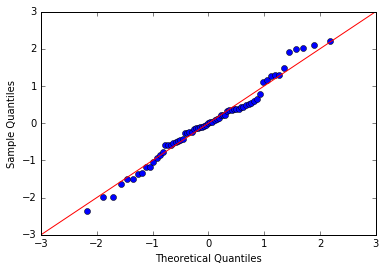

In [67]:
%matplotlib inline
import statsmodels.api as sm
from matplotlib import pyplot as plt

residuals = linreg.predict(Xtrain) - ytrain

fig = sm.qqplot(residuals,fit=True,line='45')
plt.show()